In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize

In [2]:
def get_pairs(nx, ny):
    """return indices for all pairs {i,j}: (i_x, i_y, j_x, j_y)
    """
    pairs = []
    for x in range(nx):
        for y in range(ny):
            if x+1 < nx:
                pair = [x, y, x+1, y]
                pairs.append(pair)
            if x-1 >= 0:
                pair = [x, y, x-1, y]
                pairs.append(pair)
            if y+1 < ny:
                pair = [x, y, x, y+1]
                pairs.append(pair)
            if y-1 >= 0:
                pair = [x, y, x, y-1]
                pairs.append(pair)
    pairs = np.array(pairs)
    
    return pairs

def cost_func(ofst, a=None, pairs=[], d_pairs=[]):
    """ofst is the (flattened) offset matrix 
    with the same number of dimension (nx*ny) as the image (a).
    """
    assert len(pairs)>0
    assert len(pairs) == len(d_pairs)
    assert a is not None
    nx, ny = a.shape
    
    i_x, i_y, j_x, j_y = (pairs[:,0], 
                          pairs[:,1],
                          pairs[:,2],
                          pairs[:,3],
                         )
    
    idx_i = i_x*ny + i_y
    idx_j = j_x*ny + j_y
    
    obj = np.sum(np.power(d_pairs + ofst[idx_i] - ofst[idx_j], 2))
        
    return obj

# a toy example

In [3]:
nx, ny = 3,4
a = np.random.randn(nx, ny)
a = a - np.mean(a)

<AxesSubplot:>

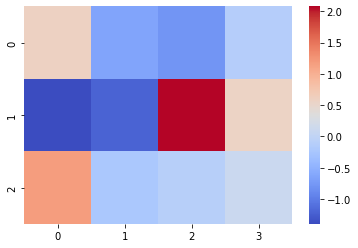

In [4]:
sns.heatmap(a, cmap='coolwarm')

In [5]:
# get all pairs
pairs = get_pairs(nx, ny)
# get Overlap difference for all pairs
d_pairs = a[pairs[:,0], pairs[:,1]] - a[pairs[:,2], pairs[:,3]]
print(pairs.shape, d_pairs.shape)

(34, 4) (34,)


In [6]:
# sanity check offset by negative a should give 0
cost0 = cost_func(-a.reshape(-1,), a=a, pairs=pairs, d_pairs=d_pairs)
# sanity check offset by other things will give nonzero
cost1 = cost_func(np.random.randn(nx*ny), a=a, pairs=pairs, d_pairs=d_pairs)
cost0, cost1

(9.013352139732264e-32, 175.17713721101285)

In [7]:
# optimize the ofst by the cost function and regularization (to promote small ofst)
res = minimize(lambda ofst: cost_func(ofst, a=a, pairs=pairs, d_pairs=d_pairs)+1e-3*ofst.dot(ofst), 
               np.random.randn(nx*ny),
              )
# result
res_offset = res.x.reshape(nx, ny)
res

      fun: 0.010914950598092448
 hess_inv: array([[41.81403665, 41.69744043, 41.64165154, 41.6217145 , 41.7053105 ,
        41.66189817, 41.62936254, 41.61206859, 41.65847889, 41.63940858,
        41.61549318, 41.59955787],
       [41.69744043, 41.75682903, 41.67685345, 41.64868517, 41.66217827,
        41.67063964, 41.64807447, 41.63253192, 41.63731735, 41.63897409,
        41.62717579, 41.61627807],
       [41.64165154, 41.67685345, 41.76412516, 41.70977444, 41.62900111,
        41.64769959, 41.67761751, 41.67169809, 41.61734008, 41.62992602,
        41.64413104, 41.64580407],
       [41.6217145 , 41.64868517, 41.70977444, 41.8288595 , 41.61544134,
        41.63550983, 41.67317739, 41.7184165 , 41.60990002, 41.62499919,
        41.65025281, 41.67375733],
       [41.7053105 , 41.66217827, 41.62900111, 41.61544134, 41.77271832,
        41.67692705, 41.63278764, 41.61313898, 41.70464642, 41.66347042,
        41.62679265, 41.60609337],
       [41.66189817, 41.67063964, 41.64769959, 41.63

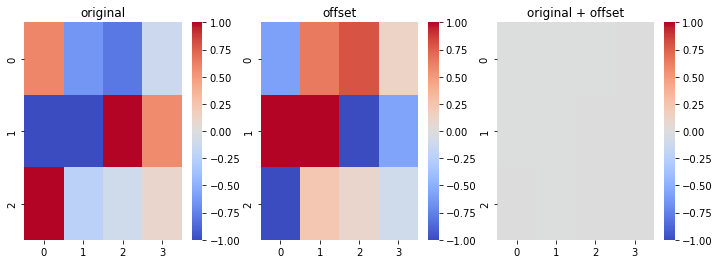

In [8]:
fig, axs = plt.subplots(1,3,figsize=(4*3,4))
ax = axs[0]
sns.heatmap(a,            cmap='coolwarm', ax=ax, vmax=1, vmin=-1)
ax.set_title('original')
ax = axs[1]
sns.heatmap(res_offset,   cmap='coolwarm', ax=ax, vmax=1, vmin=-1)
ax.set_title('offset')
ax = axs[2]
sns.heatmap(a+res_offset, cmap='coolwarm', ax=ax, vmax=1, vmin=-1)
ax.set_title('original + offset')
plt.show()

# a larger toy example

In [9]:
nx, ny = 20,20 
# FUTURE: more than 20x20 becomes much slower than 10 seconds with scipy.optmize; 
# which can be resolved by specialized quadratic programming.
a = np.random.randn(nx, ny)
a = a - np.mean(a)

<AxesSubplot:>

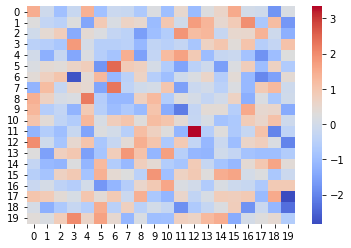

In [10]:
sns.heatmap(a, cmap='coolwarm')

In [11]:
# get all pairs
pairs = get_pairs(nx, ny)
# get Overlap difference for all pairs
d_pairs = a[pairs[:,0], pairs[:,1]] - a[pairs[:,2], pairs[:,3]]
print(pairs.shape, d_pairs.shape)

(1520, 4) (1520,)


In [12]:
# sanity check offset by negative a should give 0
cost0 = cost_func(-a.reshape(-1,), a=a, pairs=pairs, d_pairs=d_pairs)
# sanity check offset by other things will give nonzero
cost1 = cost_func(np.random.randn(nx*ny), a=a, pairs=pairs, d_pairs=d_pairs)
cost0, cost1

(9.026580871037774e-30, 5665.599930189538)

In [13]:
%%time
# optimize the ofst by the cost function and regularization (to promote small ofst)
res = minimize(lambda ofst: cost_func(ofst, a=a, pairs=pairs, d_pairs=d_pairs)+1e-3*ofst.dot(ofst), 
               np.random.randn(nx*ny),
              )
# result
res_offset = res.x.reshape(nx, ny)
# res

CPU times: user 4min 13s, sys: 15.3 s, total: 4min 28s
Wall time: 8.83 s


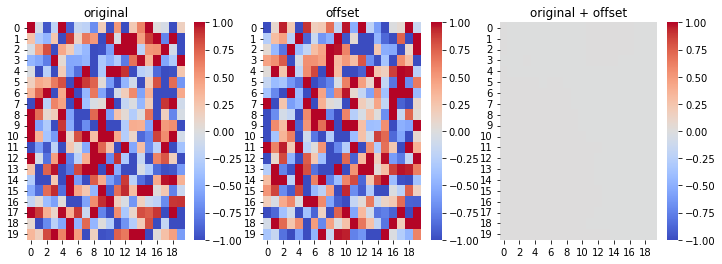

In [14]:
fig, axs = plt.subplots(1,3,figsize=(4*3,4))
ax = axs[0]
sns.heatmap(a,            cmap='coolwarm', ax=ax, vmax=1, vmin=-1)
ax.set_title('original')
ax = axs[1]
sns.heatmap(res_offset,   cmap='coolwarm', ax=ax, vmax=1, vmin=-1)
ax.set_title('offset')
ax = axs[2]
sns.heatmap(a+res_offset, cmap='coolwarm', ax=ax, vmax=1, vmin=-1)
ax.set_title('original + offset')
plt.show()